In [4]:
import sys
if 'src' not in sys.path:
    sys.path.append('src')
    
from scipy.stats import kendalltau,spearmanr,pearsonr,gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

np.random.seed(42)

cell_line = "hepg2"
seeds = [1337, 2714, 5040, 5452, 5895, 5994, 6286, 8737, 9354, 9597]

pred_dim = 200

variance_list = []
predictions_list = []
for i, seed in enumerate(seeds):
    results = np.load(f'/Users/AAYUSH/Desktop/UniversalEPI/results/{cell_line}/paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-var-beta-neg-s{seed}/results.npz')
    # results = np.load(f'../results/{cell_line}/paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-var-beta-neg-s{seed}/results.npz')
    if i == 0:
        targets = np.reshape(results['targets'], [-1, pred_dim])
    predictions_seed = np.reshape(results['predictions'], [-1, pred_dim])
    variance_seed = np.reshape(results['variance'], [-1, pred_dim])
    variance_list.append(variance_seed)
    predictions_list.append(predictions_seed)
aleatoric_uncertainty = np.mean(variance_list, axis=0)
predictions = np.mean(predictions_list, axis=0)
predictions_std = np.std(predictions_list, axis=0, ddof=1)
epistemic_uncertainty = predictions_std**2
variance = aleatoric_uncertainty + epistemic_uncertainty
predictions = np.clip(predictions, 0, None)

res = 5000
chr_data = np.reshape(results['chr'], [-1, pred_dim])
pos1 = np.reshape(results['pos1'], [-1, pred_dim])//res
pos2 = np.reshape(results['pos2'], [-1, pred_dim])//res
print(targets.shape, predictions.shape, chr_data.shape, pos1.shape, pos2.shape)

(35088, 200) (35088, 200) (35088, 200) (35088, 200) (35088, 200)


In [5]:
# Create result dataframe
result_df = pd.DataFrame({
    'chrom': chr_data.flatten(),
    'bin1': pos1.flatten(),
    'bin2': pos2.flatten(),
    'target': targets.flatten(),
    'preds': predictions.flatten(),
    'variance': variance.flatten(),
})
result_df['dist'] = abs(result_df['bin2']-result_df['bin1'])
result_df = result_df[result_df.dist < 203]

In [12]:
# Remove unmappable regions
unmap = pd.read_csv("../data/blacklist/basenji_unmappable.bed", sep="\t", names=["chr", "start", "end"])
test_chr = [*result_df.chrom.unique()]
test_chr = [f'chr{str(int(chr))}' for chr in test_chr]
unmap = unmap[unmap.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    unmap_chr = unmap[unmap.chr == chr]
    chr = int(chr.split("chr")[-1])
    drop_list = []
    for _,row in tqdm(unmap_chr.iterrows()):
        start = row['start']
        end = row['end']
        skip_regions = []
        i = start
        while i<end:
            skip_regions.append(i//5000)
            i+=5000
        drop_list.extend(skip_regions)
    drop_info[chr] = drop_list

final_df = []
for chr, drop_list in drop_info.items():
    df_filter = result_df[result_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    final_df.append(df_filter)
final_df = pd.concat(final_df, ignore_index=True)
final_df.head()

46535it [00:01, 37513.37it/s]
114616it [00:02, 44247.52it/s]
78231it [00:01, 44355.13it/s]


,chrom,bin1,bin2,target,preds,variance,dist
0,19.0,213.0,234.0,4.192472,3.529265,0.560430,21.0
1,19.0,213.0,234.0,4.192472,3.539342,0.532250,21.0
2,19.0,213.0,234.0,4.192472,3.526241,0.551288,21.0
3,19.0,213.0,234.0,4.192472,3.522149,0.567110,21.0
4,19.0,213.0,234.0,4.192472,3.540891,0.514224,21.0


In [13]:
# Remove general blacklisted regions
blacklist = pd.read_csv("../data/blacklist/basenji_blacklist.bed", sep="\t", names=["chr", "start", "end"])
blacklist = blacklist[blacklist.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    blacklist_chr = blacklist[blacklist.chr == chr]
    chr = int(chr.split("chr")[-1])
    drop_list = []
    for _,row in tqdm(blacklist_chr.iterrows()):
        start = row['start']
        end = row['end']
        skip_regions = []
        i = start
        while i<=end:
            skip_regions.append(i//5000)
            i+=5000
        drop_list.extend(skip_regions)
    drop_info[chr] = drop_list

df_list = []
for chr, drop_list in drop_info.items():
    df_filter = final_df[final_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    df_list.append(df_filter)
final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

869it [00:00, 30786.03it/s]
183it [00:00, 34194.22it/s]
73it [00:00, 36136.46it/s]


,chrom,bin1,bin2,target,preds,variance,dist
0,19.0,213.0,234.0,4.192472,3.529265,0.560430,21.0
1,19.0,213.0,234.0,4.192472,3.539342,0.532250,21.0
2,19.0,213.0,234.0,4.192472,3.526241,0.551288,21.0
3,19.0,213.0,234.0,4.192472,3.522149,0.567110,21.0
4,19.0,213.0,234.0,4.192472,3.540891,0.514224,21.0


In [14]:
# Remove cell-type-specific blacklisted regions
blacklist = pd.read_csv(f"../data/blacklist/{cell_line.lower()}_blacklist.bed", sep="\t", names=["chr", "start", "end"])
blacklist = blacklist[blacklist.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    blacklist_chr = blacklist[blacklist.chr == chr]
    chr = int(chr.split("chr")[-1])
    blacklist_chr['bin1'] = blacklist_chr.start//5000
    
    drop_list = []
    for _,row in tqdm(blacklist_chr.iterrows()):
        start = row['bin1']
        skip_regions = [start, start+1, start-1]
        drop_list.extend(skip_regions)
    
    drop_info[chr] = drop_list

df_list = []
for chr, drop_list in drop_info.items():
    df_filter = final_df[final_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    df_list.append(df_filter)
final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

<ipython-input-14-3d057c0f0cc2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacklist_chr['bin1'] = blacklist_chr.start//5000
316it [00:00, 38860.06it/s]
2551it [00:00, 48593.34it/s]
1369it [00:00, 27844.33it/s]


,chrom,bin1,bin2,target,preds,variance,dist
0,19.0,213.0,234.0,4.192472,3.529265,0.560430,21.0
1,19.0,213.0,234.0,4.192472,3.539342,0.532250,21.0
2,19.0,213.0,234.0,4.192472,3.526241,0.551288,21.0
3,19.0,213.0,234.0,4.192472,3.522149,0.567110,21.0
4,19.0,213.0,234.0,4.192472,3.540891,0.514224,21.0


In [15]:
# Chromosome-wise correlation
for chr in test_chr:
    chr = int(chr.split("chr")[-1])
    df_chr = final_df[final_df.chrom == chr] 
    
    p1 = pearsonr(df_chr['preds'].values, df_chr['target'])[0]
    s1 = spearmanr(df_chr['preds'].values, df_chr['target'])[0]
    t1 = kendalltau(df_chr['preds'].values, df_chr['target'])[0]
    print("UniversalEPI")
    print(f"{cell_line}({chr}): \t R: {np.round(p1,3)}; Rho: {np.round(s1,3)}; Tau: {np.round(t1,3)}")

UniversalEPI
hepg2(19): 	 R: 0.956; Rho: 0.94; Tau: 0.794
UniversalEPI
hepg2(2): 	 R: 0.948; Rho: 0.933; Tau: 0.788
UniversalEPI
hepg2(6): 	 R: 0.959; Rho: 0.945; Tau: 0.801


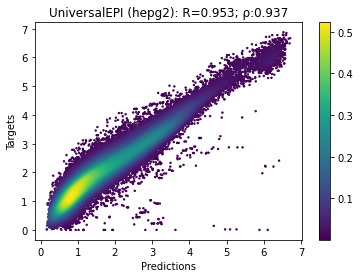

In [16]:
# Final scatter plot
t_b = np.array(final_df['target'].values.tolist())
t_hat_b = np.array(final_df['preds'].values.tolist())
r = np.round(pearsonr(t_b, t_hat_b)[0],3)
rho = np.round(spearmanr(t_b, t_hat_b)[0],3)
idx_subset = np.random.choice(np.arange(len(t_b)), size=50000, replace=False)
t_b_subset = t_b[idx_subset]
t_hat_b_subset = t_hat_b[idx_subset]
xy = np.vstack([t_hat_b_subset, t_b_subset])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
t_hat_b_subset, t_b_subset, z = t_hat_b_subset[idx], t_b_subset[idx], z[idx]
plt.scatter(t_hat_b_subset, t_b_subset, c=z, s=2)
plt.title(f"UniversalEPI ({cell_line}): R={r}; ρ:{rho}")
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.colorbar()
plt.show()    

Text(0.5, 0.98, 'Distance Stratified Correlation')

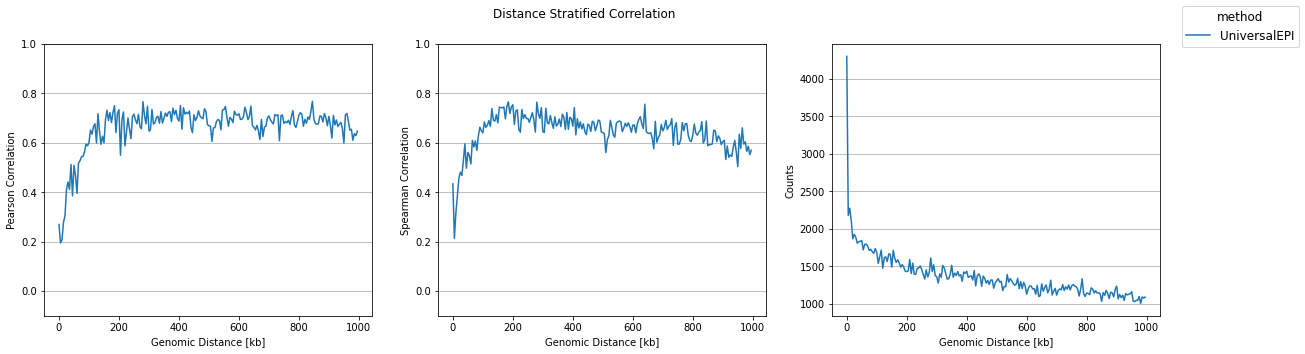

In [17]:
r_d_200 = []
rho_d_200 = []
n_samples = []

for index in range(np.uint(1000000/res)):
    t_b_i = np.array(final_df[final_df.dist == index]['target'].values.tolist())
    t_hat_b_i = np.array(final_df[final_df.dist == index]['preds'].values.tolist())

    n_samples.append(len(np.array(t_b_i).flatten()))
    
    r_d_200.append(pearsonr(np.array(t_b_i).flatten(), np.array(t_hat_b_i).flatten())[0])
    rho, _ = spearmanr(np.array(t_b_i).flatten(), np.array(t_hat_b_i).flatten())
    rho_d_200.append(rho)

x_label = np.arange(0,len(r_d_200)) * res / 1000

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].plot(x_label, np.array(r_d_200), label="UniversalEPI")
ax[0].grid(axis='y')
ax[0].set_ylim(-0.1,1)
ax[0].set_xlabel("Genomic Distance [kb]")
ax[0].set_ylabel("Pearson Correlation")

ax[1].plot(x_label, np.array(rho_d_200), label="UniversalEPI")
ax[1].grid(axis='y')
ax[1].set_ylim(-0.1,1)
ax[1].set_xlabel("Genomic Distance [kb]")
ax[1].set_ylabel("Spearman Correlation")

ax[2].plot(x_label, np.array(n_samples), label="UniversalEPI")
ax[2].grid(axis='y')
ax[2].set_xlabel("Genomic Distance [kb]")
ax[2].set_ylabel("Counts")

lines, labels = ax[1].get_legend_handles_labels()
f.legend(lines, labels, loc="upper right", title="method", fontsize='large', title_fontsize='large')
f.suptitle("Distance Stratified Correlation")

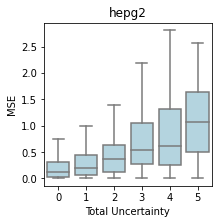

In [ ]:
# Histogram of MSE stratified by uncertainty
import seaborn as sns
final_df['mse'] = (final_df['target']-final_df['preds'])**2
final_df = final_df[final_df['mse'] < 30]
bins = [0, 1, 2, 3, 4, 5]
bin_labels = ['0', '1', '2', '3', '4']
final_df['binned_var'] = pd.cut(final_df['variance'], bins=bins, labels=bin_labels, include_lowest=True)
final_df['binned_var'] = final_df['binned_var'].astype(str)
final_df['binned_var'] = final_df['binned_var'].replace('nan', '5')
plt.figure(figsize=(3, 3))
sns.boxplot(data=final_df, x='binned_var', y='mse', color='lightblue', showfliers=False)
plt.xlabel('Total Uncertainty')
plt.ylabel('MSE')
plt.title(f"{cell_line}")
plt.show()